In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit.primitives import Estimator
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.utils import algorithm_globals

In [2]:
#########H2_op.numqubit=2

from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

In [3]:
#######Parameterized circuit

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam"), 
          Parameter("theta1"), Parameter("phi1"), Parameter("lam1")]

qr = QuantumRegister(2, name="q")
circ = QuantumCircuit(qr)
circ.u(params[0], params[1], params[2], qr[0])
circ.u(params[3], params[4], params[5], qr[1])
 
print(circ)

       ┌──────────────────┐ 
q_0: ──┤ U(theta,phi,lam) ├─
     ┌─┴──────────────────┴┐
q_1: ┤ U(theta1,phi1,lam1) ├
     └─────────────────────┘


In [4]:
estimator = Estimator()
optimizers = [SLSQP(maxiter=500), COBYLA(maxiter=500), L_BFGS_B(maxiter=500)]

converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 0
    
    ansatz = circ
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    k = np.random.rand(6)*np.pi*2 #pick random points
    
    vqe = VQE(estimator, ansatz, optimizer, initial_point = k, callback=store_intermediate_result)
    
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    
#     print(result)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimization complete      


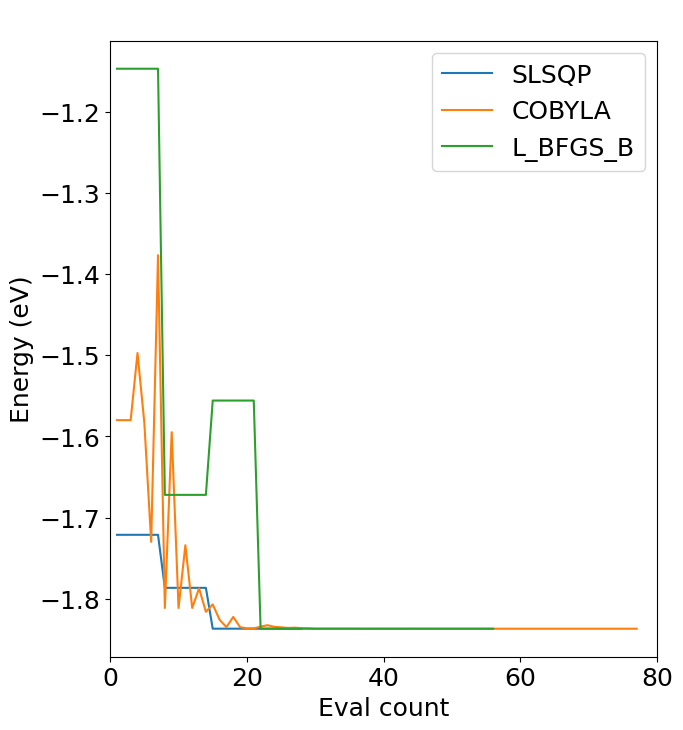

In [5]:
from jarvis.core.kpoints import Kpoints3D as Kpoints
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(1, 3)
plt.rcParams['figure.figsize'] = (24, 8)
plt.rcParams.update({'font.size': 18})
plt.subplot(the_grid[0])

plt.rcParams['figure.figsize'] = (24, 8)
plt.rcParams.update({'font.size': 18})
for i, optimizer in enumerate(optimizers):
    plt.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
plt.xlabel('Eval count')
plt.ylabel('Energy (eV)')
#pylab.title('Energy convergence for various optimizers')
plt.legend(loc='upper right');
plt.xlim([0,80])
plt.title(' ')

plt.show()